In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import os
import copy
import glob
%matplotlib widget

# Paths

In [ ]:
demand_df_path = r".\Demand_data_with_class_2022_2023.csv"

# Data cleaning

In [ ]:
demand_df_shortImputed = pd.read_csv(demand_df_path, parse_dates=["Unnamed: 0"], index_col=0)
demand_df_shortImputed.index = pd.to_datetime(demand_df_shortImputed.index)
demand_df = demand_df_shortImputed.copy()
demand_df

,Power,Temperature,Class
2022-01-01 00:00:00,NaN,13.40,Vacation
2022-01-01 01:00:00,NaN,12.90,Vacation
2022-01-01 02:00:00,NaN,12.50,Vacation
2022-01-01 03:00:00,NaN,12.00,Vacation
2022-01-01 04:00:00,NaN,13.00,Vacation
...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation
2023-12-31 20:00:00,3.30,16.11,Vacation
2023-12-31 21:00:00,3.25,16.11,Vacation
2023-12-31 22:00:00,NaN,16.11,Vacation


In [4]:
demand_df_2022 = demand_df["2022-01-01": "2022-12-31"]
demand_df_2022

,Power,Temperature,Class
2022-01-01 00:00:00,NaN,13.4,Vacation
2022-01-01 01:00:00,NaN,12.9,Vacation
2022-01-01 02:00:00,NaN,12.5,Vacation
2022-01-01 03:00:00,NaN,12.0,Vacation
2022-01-01 04:00:00,NaN,13.0,Vacation
...,...,...,...
2022-12-31 19:00:00,2.7,18.0,Vacation
2022-12-31 20:00:00,NaN,17.0,Vacation
2022-12-31 21:00:00,2.7,15.4,Vacation
2022-12-31 22:00:00,2.5,17.0,Vacation


In [5]:
demand_df_used = demand_df_2022.copy()
demand_df_used

,Power,Temperature,Class
2022-01-01 00:00:00,NaN,13.4,Vacation
2022-01-01 01:00:00,NaN,12.9,Vacation
2022-01-01 02:00:00,NaN,12.5,Vacation
2022-01-01 03:00:00,NaN,12.0,Vacation
2022-01-01 04:00:00,NaN,13.0,Vacation
...,...,...,...
2022-12-31 19:00:00,2.7,18.0,Vacation
2022-12-31 20:00:00,NaN,17.0,Vacation
2022-12-31 21:00:00,2.7,15.4,Vacation
2022-12-31 22:00:00,2.5,17.0,Vacation


### Creating Time features

In [6]:
demand_df_used["hour"] = demand_df_used.index.hour
demand_df_used["dayofweek"] = demand_df_used.index.dayofweek
demand_df_used["month"] = demand_df_used.index.month
demand_df_used

,Power,Temperature,Class,hour,dayofweek,month
2022-01-01 00:00:00,NaN,13.4,Vacation,0,5,1
2022-01-01 01:00:00,NaN,12.9,Vacation,1,5,1
2022-01-01 02:00:00,NaN,12.5,Vacation,2,5,1
2022-01-01 03:00:00,NaN,12.0,Vacation,3,5,1
2022-01-01 04:00:00,NaN,13.0,Vacation,4,5,1
...,...,...,...,...,...,...
2022-12-31 19:00:00,2.7,18.0,Vacation,19,5,12
2022-12-31 20:00:00,NaN,17.0,Vacation,20,5,12
2022-12-31 21:00:00,2.7,15.4,Vacation,21,5,12
2022-12-31 22:00:00,2.5,17.0,Vacation,22,5,12


# Model Training (class-wise)

In [7]:
from sklearn.ensemble import HistGradientBoostingRegressor

class_models = {}

feature_cols = ["Temperature", "hour", "dayofweek", "month"]

for cls in demand_df_used["Class"].unique():

    df_cls = demand_df_used[demand_df_used["Class"] == cls].copy()

    df_cls = df_cls.dropna(subset=["Power"])

    df_cls = df_cls.sort_index()

    if len(df_cls) < 100:
        print(f"Skipping class {cls}: insufficient data")
        continue

    # Train–test split index
    split_idx = int(0.9 * len(df_cls))

    train_df = df_cls.iloc[:split_idx]
    test_df  = df_cls.iloc[split_idx:]

    X_train = train_df[feature_cols]
    y_train = train_df["Power"]

    model = HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.03,
        max_iter=600,
        min_samples_leaf=20,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Storing trained model
    class_models[cls] = model

    print(f"Trained model for class: {cls} | Samples: {len(df_cls)}")


Trained model for class: Vacation | Samples: 1277
Trained model for class: Weekend | Samples: 762
Trained model for class: Working_Days | Samples: 1741
Skipping class Short_Holiday: insufficient data
Skipping class Exam: insufficient data
Skipping class Long_Holiday: insufficient data


In [8]:
class_models.keys()

dict_keys(['Vacation', 'Weekend', 'Working_Days'])

#### NOTE: Since we have very less samples for Short_Holiday, Long_Holiday, Fest and Exam, so we use a fall back class map as shown below

In [9]:
fallback_class_map = {
    "Fest": "Working_Days",
    "Exam": "Working_Days",
    "Short_Holiday": "Weekend",
    "Long_Holiday": "Vacation"
}

# Prediction

In [10]:
from sklearn.metrics import r2_score

demand_df_used["PredictedPower"] = np.nan

feature_cols = ["Temperature", "hour", "dayofweek", "month"]

for idx, row in demand_df_used.iterrows():                      

    cls = row["Class"]

    model_class = fallback_class_map.get(cls, cls)
    if model_class not in class_models:
        continue

    model = class_models[model_class]

    X_row = pd.DataFrame([row[feature_cols]], columns=feature_cols)
    demand_df_used.at[idx, "PredictedPower"] = model.predict(X_row)[0]
    

In [11]:
demand_df_used

,Power,Temperature,Class,hour,dayofweek,month,PredictedPower
2022-01-01 00:00:00,NaN,13.4,Vacation,0,5,1,3.431082
2022-01-01 01:00:00,NaN,12.9,Vacation,1,5,1,2.999698
2022-01-01 02:00:00,NaN,12.5,Vacation,2,5,1,2.855227
2022-01-01 03:00:00,NaN,12.0,Vacation,3,5,1,2.770830
2022-01-01 04:00:00,NaN,13.0,Vacation,4,5,1,2.789302
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2.7,18.0,Vacation,19,5,12,3.101806
2022-12-31 20:00:00,NaN,17.0,Vacation,20,5,12,3.012506
2022-12-31 21:00:00,2.7,15.4,Vacation,21,5,12,2.899994
2022-12-31 22:00:00,2.5,17.0,Vacation,22,5,12,2.754485


In [12]:
demand_df_used.PredictedPower.isna().sum()

np.int64(0)

### R^2 Evaluation

In [13]:
valid_idx = demand_df_used["Power"].notna()

df_valid = demand_df_used.loc[valid_idx]

test_df = df_valid.sample(frac=0.10, random_state=None)

y_true = test_df["Power"]
y_pred = test_df["PredictedPower"]

r2 = r2_score(y_true, y_pred)

print(f"Random 10% Test R²: {r2:.3f}")


Random 10% Test R²: 0.912


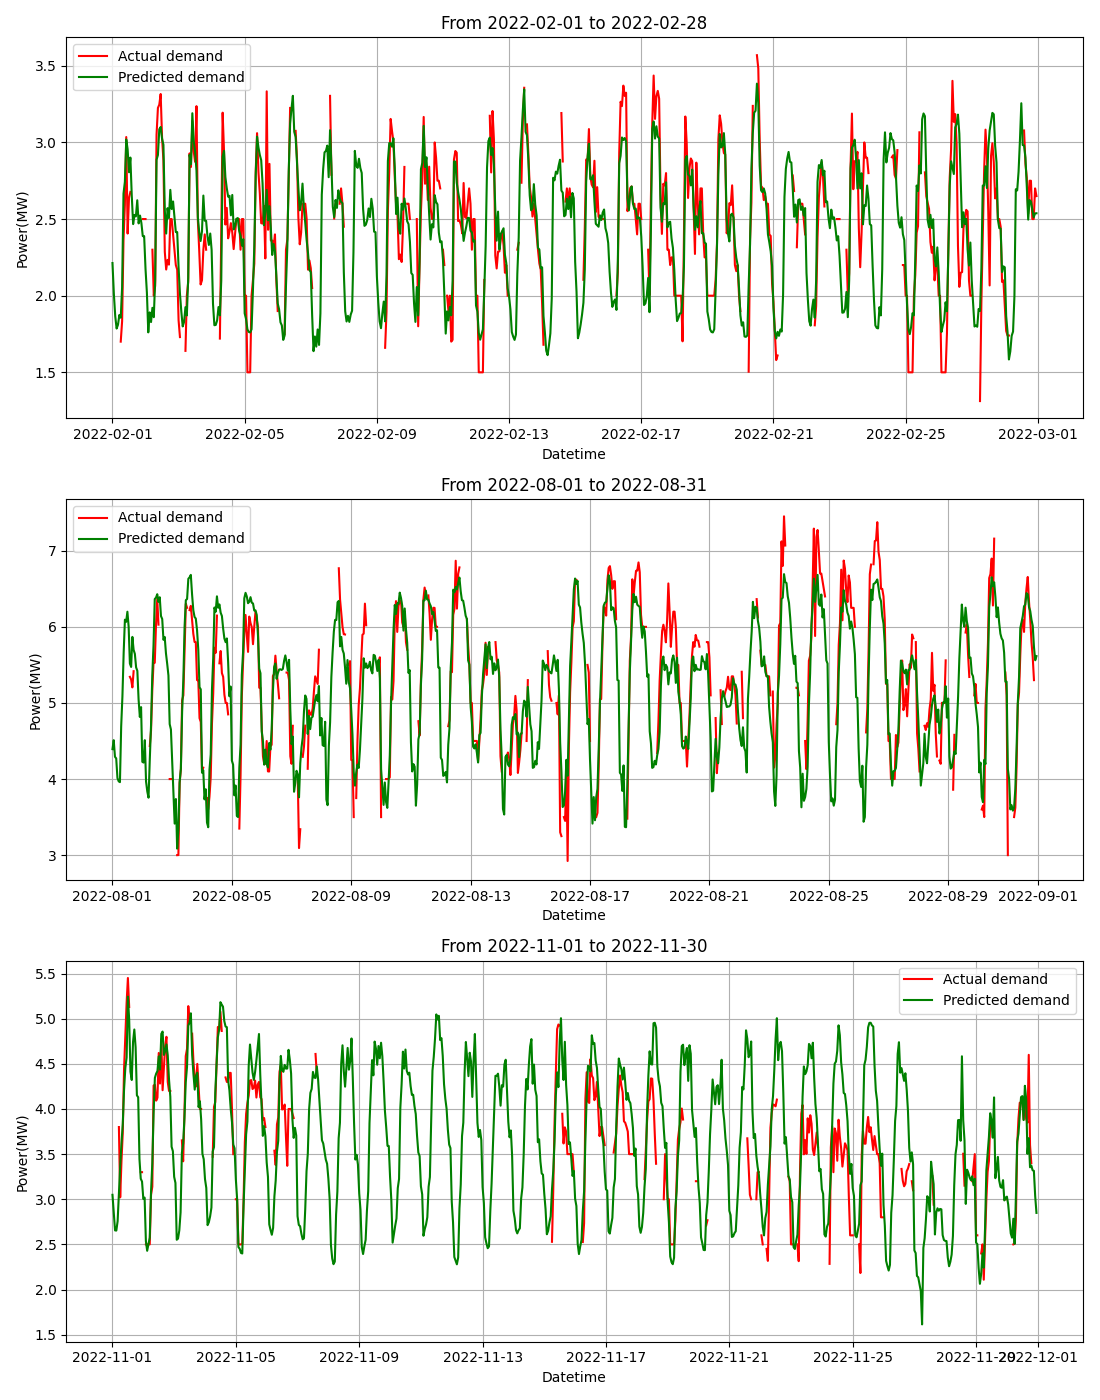

In [14]:
fig, axes = plt.subplots(3, 1,figsize=(11, 14))
ax1, ax2, ax3 = axes.flatten()

ax1.plot(demand_df_used.loc["2022-02-01": "2022-02-28"].index, demand_df_used.loc["2022-02-01": "2022-02-28", "Power"], label="Actual demand", color="red")
ax1.plot(demand_df_used.loc["2022-02-01": "2022-02-28"].index, demand_df_used.loc["2022-02-01": "2022-02-28", "PredictedPower"], label="Predicted demand", color="green")
ax1.grid()
ax1.legend()
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Power(MW)")
ax1.set_title("From 2022-02-01 to 2022-02-28")

ax2.plot(demand_df_used.loc["2022-08-01": "2022-08-31"].index, demand_df_used.loc["2022-08-01": "2022-08-31", "Power"], label="Actual demand", color="red")
ax2.plot(demand_df_used.loc["2022-08-01": "2022-08-31"].index, demand_df_used.loc["2022-08-01": "2022-08-31", "PredictedPower"], label="Predicted demand", color="green")
ax2.grid()
ax2.legend()
ax2.set_xlabel("Datetime")
ax2.set_ylabel("Power(MW)")
ax2.set_title("From 2022-08-01 to 2022-08-31")

ax3.plot(demand_df_used.loc["2022-11-01": "2022-11-30"].index, demand_df_used.loc["2022-11-01": "2022-11-30", "Power"], label="Actual demand", color="red")
ax3.plot(demand_df_used.loc["2022-11-01": "2022-11-30"].index, demand_df_used.loc["2022-11-01": "2022-11-30", "PredictedPower"], label="Predicted demand", color="green")
ax3.grid()
ax3.legend()
ax3.set_xlabel("Datetime")
ax3.set_ylabel("Power(MW)")
ax3.set_title("From 2022-11-01 to 2022-11-30")

plt.tight_layout()
plt.show()

# Imputing

In [15]:
isMissing = demand_df_used["Power"].isna()
demand_df_used["LongImputedPower"] = demand_df_used.Power.values
demand_df_used.loc[isMissing, "LongImputedPower"] = demand_df_used.loc[isMissing, "PredictedPower"]
demand_df_used

,Power,Temperature,Class,hour,dayofweek,month,PredictedPower,LongImputedPower
2022-01-01 00:00:00,NaN,13.4,Vacation,0,5,1,3.431082,3.431082
2022-01-01 01:00:00,NaN,12.9,Vacation,1,5,1,2.999698,2.999698
2022-01-01 02:00:00,NaN,12.5,Vacation,2,5,1,2.855227,2.855227
2022-01-01 03:00:00,NaN,12.0,Vacation,3,5,1,2.770830,2.770830
2022-01-01 04:00:00,NaN,13.0,Vacation,4,5,1,2.789302,2.789302
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2.7,18.0,Vacation,19,5,12,3.101806,2.700000
2022-12-31 20:00:00,NaN,17.0,Vacation,20,5,12,3.012506,3.012506
2022-12-31 21:00:00,2.7,15.4,Vacation,21,5,12,2.899994,2.700000
2022-12-31 22:00:00,2.5,17.0,Vacation,22,5,12,2.754485,2.500000


In [16]:
print("Actual Peak Power for 2022 = ", demand_df_used.max().Power, "\nPredicted Peak Power for 2022 = ", demand_df_used.max().PredictedPower)
print("Actual Power date = ", demand_df_used.Power.idxmax(), "\nPredicted Power date = ", demand_df_used.PredictedPower.idxmax())

Actual Peak Power for 2022 =  7.452957400000001 
Predicted Peak Power for 2022 =  6.723033411550275
Actual Power date =  2022-08-23 12:00:00 
Predicted Power date =  2022-09-09 11:00:00


In [17]:
from sklearn.metrics import mean_absolute_error

mask_2022 = demand_df_used["Power"].notna() & demand_df_used["PredictedPower"].notna()

y_true_2022 = demand_df_used.loc[mask_2022, "Power"].values
y_pred_2022 = demand_df_used.loc[mask_2022, "PredictedPower"].values

mae_2022_model2 = mean_absolute_error(y_true_2022, y_pred_2022)
print("Model 2 — MAE for 2022:", mae_2022_model2, "MW")


Model 2 — MAE for 2022: 0.24914209443345184 MW


In [18]:
mask_2022_m2 = (
    demand_df_used["Power"].notna() &
    demand_df_used["PredictedPower"].notna() &
    (demand_df_used["Power"] > 0)
)

y_true_2022_m2 = demand_df_used.loc[mask_2022_m2, "Power"].values
y_pred_2022_m2 = demand_df_used.loc[mask_2022_m2, "PredictedPower"].values

mape_2022_model2 = np.mean(np.abs((y_true_2022_m2 - y_pred_2022_m2) / y_true_2022_m2)) * 100
print("Model 2 — MAPE for 2022:", round(mape_2022_model2, 2), "%")

Model 2 — MAPE for 2022: 6.71 %


# Prediction for 2023

In [19]:
demand_df_2023 = demand_df["2023-01-01":"2023-12-31"]
demand_df_2023

,Power,Temperature,Class
2023-01-01 00:00:00,2.30,13.89,Vacation
2023-01-01 01:00:00,NaN,12.78,Vacation
2023-01-01 02:00:00,NaN,12.64,Vacation
2023-01-01 03:00:00,NaN,12.50,Vacation
2023-01-01 04:00:00,NaN,12.36,Vacation
...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation
2023-12-31 20:00:00,3.30,16.11,Vacation
2023-12-31 21:00:00,3.25,16.11,Vacation
2023-12-31 22:00:00,NaN,16.11,Vacation


In [20]:
demand_df_2023_used = demand_df_2023.copy()

In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [22]:
demand_df_2023_used.index = pd.to_datetime(demand_df_2023_used.index)

demand_df_2023_used["hour"] = demand_df_2023_used.index.hour
demand_df_2023_used["dayofweek"] = demand_df_2023_used.index.dayofweek
demand_df_2023_used["month"] = demand_df_2023_used.index.month
demand_df_2023_used

,Power,Temperature,Class,hour,dayofweek,month
2023-01-01 00:00:00,2.30,13.89,Vacation,0,6,1
2023-01-01 01:00:00,NaN,12.78,Vacation,1,6,1
2023-01-01 02:00:00,NaN,12.64,Vacation,2,6,1
2023-01-01 03:00:00,NaN,12.50,Vacation,3,6,1
2023-01-01 04:00:00,NaN,12.36,Vacation,4,6,1
...,...,...,...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation,19,6,12
2023-12-31 20:00:00,3.30,16.11,Vacation,20,6,12
2023-12-31 21:00:00,3.25,16.11,Vacation,21,6,12
2023-12-31 22:00:00,NaN,16.11,Vacation,22,6,12


In [23]:
feature_cols = ["Temperature", "hour", "dayofweek", "month"]

class_models_2022 = {}

for cls in demand_df_used["Class"].unique():

    df_cls = demand_df_used[demand_df_used["Class"] == cls].copy()
    df_cls = df_cls.dropna(subset=["LongImputedPower"])
    df_cls = df_cls.sort_index()

    if len(df_cls) < 100:
        print(f"Skipping {cls}: insufficient data")
        continue

    X = df_cls[feature_cols]
    y = df_cls["LongImputedPower"]

    model = HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.03,
        max_iter=600,
        min_samples_leaf=20,
        random_state=42
    )

    model.fit(X, y)
    class_models_2022[cls] = model

    print(f"Trained 2022 model for class: {cls} | Samples: {len(df_cls)}")


Trained 2022 model for class: Vacation | Samples: 2592
Trained 2022 model for class: Weekend | Samples: 1536
Trained 2022 model for class: Working_Days | Samples: 3912
Trained 2022 model for class: Short_Holiday | Samples: 264
Trained 2022 model for class: Exam | Samples: 288
Trained 2022 model for class: Long_Holiday | Samples: 168


In [24]:
# fallback_class_map = {
#     "Long_Holiday": "Vacation"
# }

In [25]:
demand_df_2023_used["PredictedPower"] = np.nan

for idx, row in demand_df_2023_used.iterrows():

    cls = row["Class"]
    model_class = fallback_class_map.get(cls, cls)

    if model_class not in class_models_2022:
        continue

    model = class_models_2022[model_class]

    X_row = pd.DataFrame([row[feature_cols]], columns=feature_cols)

    demand_df_2023_used.at[idx, "PredictedPower"] = model.predict(X_row)[0]


In [26]:
eval_df = demand_df_2023_used.dropna(subset=["Power", "PredictedPower"])

y_true = eval_df["Power"]
y_pred = eval_df["PredictedPower"]

mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")

MAE  : 0.594
RMSE : 0.753


In [27]:
from sklearn.metrics import r2_score, mean_absolute_error

valid2023 = demand_df_2023_used.dropna(subset=["Power", "PredictedPower"])

r2_2023  = r2_score(valid2023["Power"], valid2023["PredictedPower"])

print(f"Daily Peak R² 2023  : {r2_2023:.3f}")

Daily Peak R² 2023  : 0.687


In [28]:
demand_df_2023_used

,Power,Temperature,Class,hour,dayofweek,month,PredictedPower
2023-01-01 00:00:00,2.30,13.89,Vacation,0,6,1,3.515423
2023-01-01 01:00:00,NaN,12.78,Vacation,1,6,1,2.932884
2023-01-01 02:00:00,NaN,12.64,Vacation,2,6,1,2.675903
2023-01-01 03:00:00,NaN,12.50,Vacation,3,6,1,2.679078
2023-01-01 04:00:00,NaN,12.36,Vacation,4,6,1,2.698254
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation,19,6,12,2.812472
2023-12-31 20:00:00,3.30,16.11,Vacation,20,6,12,2.868424
2023-12-31 21:00:00,3.25,16.11,Vacation,21,6,12,2.833462
2023-12-31 22:00:00,NaN,16.11,Vacation,22,6,12,2.637607


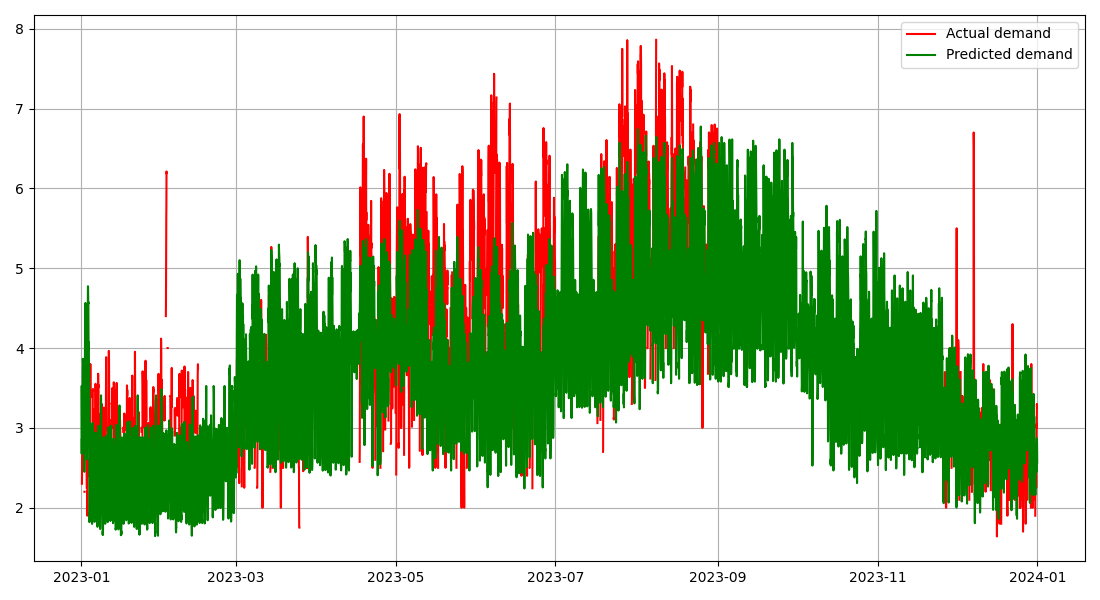

In [29]:
plt.figure(figsize=(11,6))
plt.plot(demand_df_2023_used.index, demand_df_2023_used["Power"], label = "Actual demand", color="r")
plt.plot(demand_df_2023_used.index, demand_df_2023_used["PredictedPower"], label = "Predicted demand", color="g")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
print("Actual Peak Power for 2023 = ", demand_df_2023_used.max().Power, "\nPredicted Peak Power for 2023 = ", demand_df_2023_used.max().PredictedPower)
print("Actual Power date = ", demand_df_2023_used.Power.idxmax(), "\nPredicted Power date = ", demand_df_2023_used.PredictedPower.idxmax())

Actual Peak Power for 2023 =  7.8610411 
Predicted Peak Power for 2023 =  6.7751169985168245
Actual Power date =  2023-08-08 11:00:00 
Predicted Power date =  2023-08-25 12:00:00


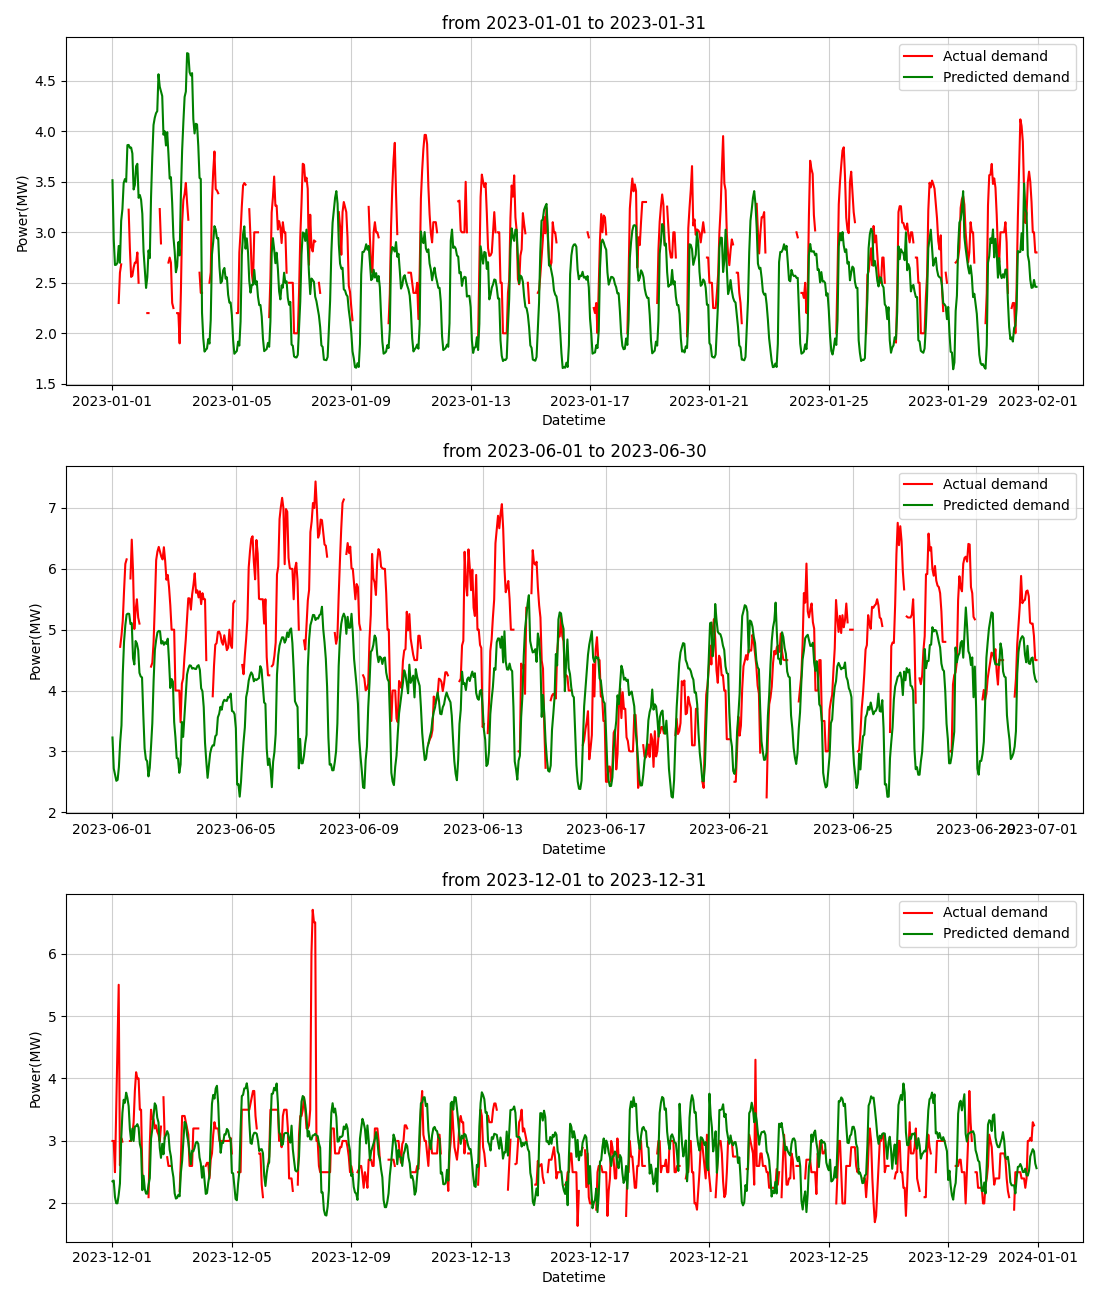

In [31]:
fig, axes = plt.subplots(3,1, figsize=(11, 13), sharex=False)
ax1, ax2, ax3 = axes.flatten()

strt1 = "2023-01-01"
end1 = "2023-01-31"
strt2 = "2023-06-01"
end2 = "2023-06-30"
strt3 = "2023-12-01"
end3 = "2023-12-31"

ax1.plot(
    demand_df_2023_used.loc[strt1:end1].index,
    demand_df_2023_used.loc[strt1:end1, "Power"],
    label="Actual demand",
    color='red')

ax1.plot(
    demand_df_2023_used.loc[strt1:end1].index,
    demand_df_2023_used.loc[strt1:end1, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Power(MW)")
ax1.legend()
ax1.set_title(f"from {strt1} to {end1}")
ax1.grid(alpha = 0.6)

ax2.plot(
    demand_df_2023_used.loc[strt2:end2].index,
    demand_df_2023_used.loc[strt2:end2, "Power"],
    label="Actual demand",
    color='red')

ax2.plot(
    demand_df_2023_used.loc[strt2:end2].index,
    demand_df_2023_used.loc[strt2:end2, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax2.set_xlabel("Datetime")
ax2.set_ylabel("Power(MW)")
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.set_title(f"from {strt2} to {end2}")


ax3.plot(
    demand_df_2023_used.loc[strt3:end3].index,
    demand_df_2023_used.loc[strt3:end3, "Power"],
    label="Actual demand",
    color='red')

ax3.plot(
    demand_df_2023_used.loc[strt3:end3].index,
    demand_df_2023_used.loc[strt3:end3, "PredictedPower"],
    label="Predicted demand",
    color='green'
)
ax3.set_xlabel("Datetime")
ax3.set_ylabel("Power(MW)")
ax3.legend()
ax3.set_title(f"from {strt3} to {end3}")
ax3.grid(alpha = 0.6)


plt.tight_layout()
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error

mask_2023 = demand_df_2023_used["Power"].notna() & demand_df_2023_used["PredictedPower"].notna()

y_true_2023 = demand_df_2023_used.loc[mask_2023, "Power"].values
y_pred_2023 = demand_df_2023_used.loc[mask_2023, "PredictedPower"].values

mae_2023_model2 = mean_absolute_error(y_true_2023, y_pred_2023)
print("Model 2 — MAE for 2023:", mae_2023_model2, "MW")


Model 2 — MAE for 2023: 0.5935328051902298 MW


In [33]:
mask_2023_m2 = (
    demand_df_2023_used["Power"].notna() &
    demand_df_2023_used["PredictedPower"].notna() &
    (demand_df_2023_used["Power"] > 0)
)

y_true_2023_m2 = demand_df_2023_used.loc[mask_2023_m2, "Power"].values
y_pred_2023_m2 = demand_df_2023_used.loc[mask_2023_m2, "PredictedPower"].values

mape_2023_model2 = np.mean(np.abs((y_true_2023_m2 - y_pred_2023_m2) / y_true_2023_m2)) * 100
print("Model 2 — MAPE for 2023:", round(mape_2023_model2, 2), "%")

Model 2 — MAPE for 2023: 14.74 %
